# Diffusion

In this notebook you will:
- Analyze one-dimensional diffusion
- Evolve a delta function initial condition
- Compare with analytic solution
- Investigate position-dependent diffusion constant: e.g. $D = D_0 \exp(- |x| / \lambda)$
- Try to solve this new problem analytically

In a nutshell:
- ...

For the future:
- ...

Resources:
- http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/sphinx/._main_diffu001.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg
import copy
%matplotlib inline

# $\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial^2 x}$

In [2]:
# Euler forward

In [3]:
def diffusion_step(c, D, dx, dt, boundary_conditions=None):
    
    # Create dimensionless coefficient cluster.
    F = D*dt/(dx**2)
    
    c_new = np.zeros(c.shape)
    
    # Update interior points.
    for i in range(1, Nx - 1):
        c_new[i] = c[i] + F*(c[i - 1] - 2 * c[i] + c[i + 1])
    
    # Impose boundary conditions.
    if boundary_conditions is None:
        boundary_conditions = [0, 0]
        
    c_new[0] = boundary_conditions[0]
    c_new[-1] = boundary_conditions[1]
    
    return c_new

In [4]:
# Discretize space
L = 10 # spatial extent
Nx = 100 # number of spatial grid points - including boundaries
xs = np.linspace(0, L, Nx)
dx = xs[1] - xs[0]

# Discretize time
T = 2 # total time of evolution
Nt = 200 # number of time grid points - including initial and final times
ts = np.linspace(0, T, Nt)
dt = ts[1] - ts[0]

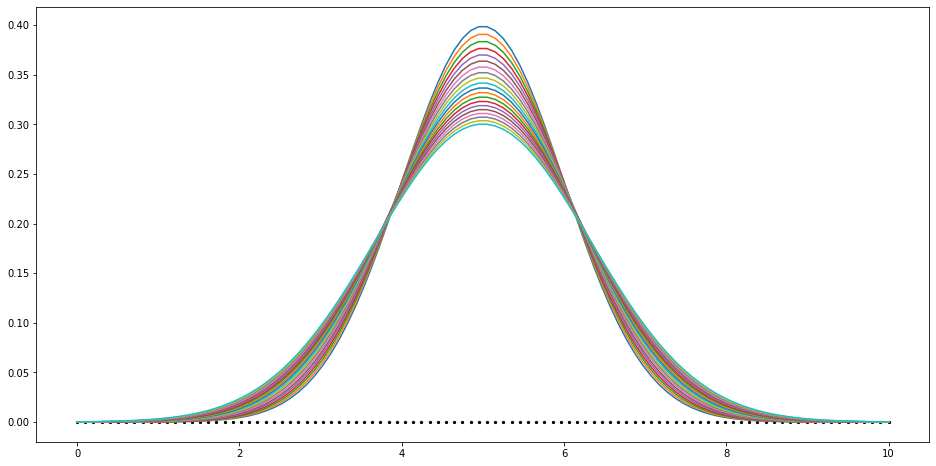

In [5]:
# Diffusion constant
D = 0.2

# Create initial condition
c = np.zeros(Nx)

# Plateau
#c[Nx//3:Nx//2] = 1 

# Random
# c = np.random.random(c.shape)

# Gaussian
# mu = L/10
mu= L/2
sigma = L/10
a = 1
c = (a / (sigma*(2*np.pi)**0.5)) * np.exp( -(1/2)*(xs - mu)**2 / sigma**2 )

# Set BCs
bcs = [0, 0]
#bcs = [0.6, 0.2]

fig = plt.figure(figsize=(16, 8))
plt.scatter(xs, 0*xs, s=5, c='k')
plt.plot(xs, c)

for tind in range(1, Nt):
    c = diffusion_step(c, D, dx, dt, boundary_conditions=bcs)

    if tind % 10 == 0:
        plt.plot(xs, c)

In [6]:
# Starting with a delta function, sometimes we observe oscillations in the function c[x]. Why? Is this a bug? Are we using the method outside of some radius of convergence?
# Find a small T where there is no oscillation, and a high T where there is. Zoom in on the critical value of T.
# Can you get any insight into what is happening in the algorithm?
# Try a few different initial conditions: linear, gaussian,.. - does this instability depend on the sharp edges of the IC?
# Explore a bit more.
# If you change dx, does the critical value of dt change?
# Make a hypothesis about what might be a critical value of F.

In [7]:
### TRY: Is the "stuff" conserved by this scheme?

In [8]:
# TODO: 
# Implement analytic solution.

In [9]:
# TRY: Add an option to the diffusion_step() function for boundary_conditions='free'. Use your intuition to come up with two different ways to implement these "free" boundary conditions. Compare your two methods - do they produce similar results?

In [10]:
# We could store all steps of the evolution. 
# That would allow us to plot as a surface which might be fun.

# Position dependence

# $\frac{\partial C}{\partial t} = \frac{\partial}{\partial x}(D \frac{\partial C}{\partial x})$

What happens when the diffusion "constant" depends on position?

Maybe go through derivation of diffusion equation?
Or maybe just motivate why the partial derivative includes $D$.

# Backward Euler algorithm

In [11]:
def diffusion_step_backward_euler(c, D, dx, dt, boundary_conditions=None):
    
    # Create dimensionless coefficient cluster.
    F = D*dt/(dx**2)
    
    c_new = np.zeros(c.shape)
    
    # TODO: no need for a new array 'b' here right?
    # Encode interior points into array b.
    for i in range(1, Nx - 1):
        b[i] = c[i] #????
#         b[i] = -c[i]
    
    # Set boundary conditions
    b[0] = 0
    b[-1] = 0
    
    # Compute new configuration.
    c_new[:] = scipy.linalg.solve(A, b)
    
    return c_new

In [12]:
# Discretize space
L = 10 # spatial extent
Nx = 100 # number of spatial grid points - including boundaries
xs = np.linspace(0, L, Nx)
dx = xs[1] - xs[0]

# Discretize time
T = 2 # total time of evolution
Nt = 200 # number of time grid points - including initial and final times
ts = np.linspace(0, T, Nt)
dt = ts[1] - ts[0]

# Data structures for the linear system
A = np.zeros((Nx, Nx))
b = np.zeros(Nx)

F = D*dt/(dx**2)

for i in range(1, Nx - 1):
    A[i, i - 1] = -F
    A[i, i + 1] = -F
    A[i, i] = 1 + 2*F

A[0, 0] = 1
A[Nx - 1, Nx - 1] = 1

# Set initial condition c(x,0) = I(x)

# Gaussian
# mu = L/10
mu= L/2
sigma = L/10
a = 1
c = (a / (sigma*(2*np.pi)**0.5)) * np.exp( -(1/2)*(xs - mu)**2 / sigma**2 )


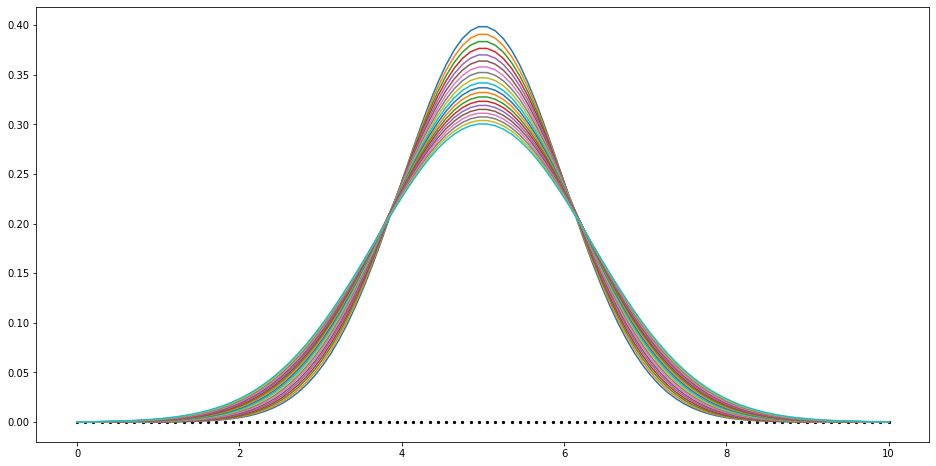

In [13]:
fig = plt.figure(figsize=(16, 8))
plt.scatter(xs, 0*xs, s=5, c='k')
plt.plot(xs, c)

for tind in range(1, Nt):
    c = diffusion_step_backward_euler(c, D, dx, dt, boundary_conditions=bcs)

    if tind % 10 == 0:
        plt.plot(xs, c)